In [67]:
# ✅ Load API Key securely from .env
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)

# ✅ Required installs (only needed in Colab)
!pip install -q pandas requests matplotlib seaborn plotly google-generativeai python-dotenv streamlit

# ✅ Core Libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import streamlit as st


In [27]:
def fetch_live_crypto_data(vs_currency="inr", per_page=50, page=1):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        'vs_currency': vs_currency,
        'order': 'market_cap_desc',
        'per_page': per_page,
        'page': page,
        'sparkline': False,  # sparkline not used now
        'price_change_percentage': '1h,24h,7d'
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception("API Error:", response.status_code, response.text)

    df = pd.DataFrame(response.json())

    # Keep only available columns
    expected_cols = [
        'id', 'name', 'symbol', 'current_price', 'market_cap_rank', 'market_cap',
        'total_volume', 'high_24h', 'low_24h', 'price_change_percentage_24h',
        'price_change_percentage_7d_in_currency', 'ath', 'ath_change_percentage',
        'circulating_supply'
    ]
    df = df[[col for col in expected_cols if col in df.columns]]

    return df


In [28]:
def get_top_movers(df, n=5):
    gainers = df.nlargest(n, 'price_change_percentage_24h')
    losers = df.nsmallest(n, 'price_change_percentage_24h')
    return gainers, losers

def calculate_volatility(df):
    df['volatility_%'] = ((df['high_24h'] - df['low_24h']) / df['current_price']) * 100
    return df

def calculate_ath_discount(df):
    df['ath_discount_%'] = -df['ath_change_percentage']
    return df

def calculate_dominance(df):
    total_market_cap = df['market_cap'].sum()
    df['dominance_%'] = (df['market_cap'] / total_market_cap) * 100
    return df

def generate_all_kpis(df):
    df = calculate_volatility(df)
    df = calculate_ath_discount(df)
    df = calculate_dominance(df)
    gainers, losers = get_top_movers(df)
    return df, gainers, losers


In [29]:
def generate_market_summary(df):
    top_gainer = df.sort_values(by="price_change_percentage_24h", ascending=False).iloc[0]
    top_loser = df.sort_values(by="price_change_percentage_24h").iloc[0]
    total_market_cap = df['market_cap'].sum()

    prompt = f"""
    Provide an in-depth market summary for the top 50 cryptocurrencies in INR.
    Include:
    - Top gainer: {top_gainer['name']} ({top_gainer['symbol']}) with a 24h change of {top_gainer['price_change_percentage_24h']:.2f}%
    - Top loser: {top_loser['name']} ({top_loser['symbol']}) with a 24h change of {top_loser['price_change_percentage_24h']:.2f}%
    - Total market cap: ₹{total_market_cap:,.0f}
    - Market sentiment
    - Volatility and supply trends
    Make it sound like a fintech analyst's weekly market brief.
    """

    model = genai.GenerativeModel("models/gemini-1.5-pro")
    response = model.generate_content(prompt)
    return response.text


In [30]:
def plot_top_gainers_losers(gainers, losers):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.barplot(y=gainers['name'], x=gainers['price_change_percentage_24h'], palette='Greens_r')
    plt.title("Top Gainers (24h)")
    plt.xlabel("% Change")

    plt.subplot(1, 2, 2)
    sns.barplot(y=losers['name'], x=losers['price_change_percentage_24h'], palette='Reds_r')
    plt.title("Top Losers (24h)")
    plt.xlabel("% Change")

    plt.tight_layout()
    plt.show()

def plot_market_dominance(df):
    top10 = df.nlargest(10, 'market_cap')
    fig = px.pie(top10, values='market_cap', names='name', title='Market Dominance (Top 10)')
    fig.show()


<ipython-input-30-295d1fffd8d8>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-30-295d1fffd8d8>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




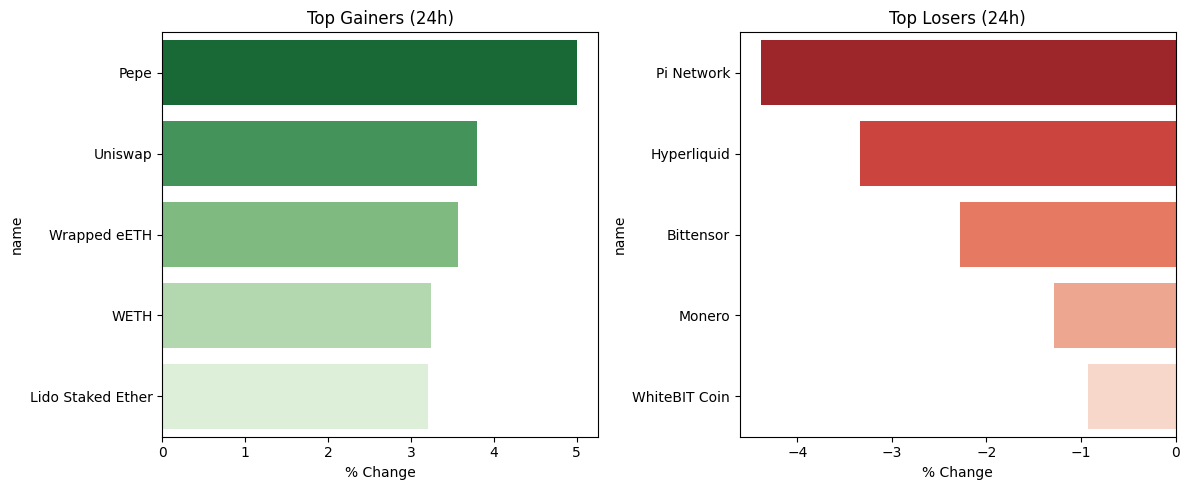

🧠 Gemini Market Summary:

**Fintech Market Brief: Cryptocurrency Market Analysis (Week Ending [Date])**

This week witnessed a mixed bag in the cryptocurrency market, with fluctuating prices and shifting investor sentiment.  The total market capitalization of the top 50 cryptocurrencies stands at ₹289,821,820,781,776 (approximately $3.5 Trillion USD equivalent), showcasing a relatively stable figure compared to the previous week, despite underlying volatility within individual assets.

**Market Movers:**

Meme coin Pepe (PEPE) emerged as the top gainer this week, boasting a 24-hour change of +5.00%. This surge underscores the continued influence of social media-driven narratives and speculation within the crypto space, even amidst broader market uncertainty.  Conversely, Pi Network (PI) experienced the largest decline, with a 24-hour change of -4.39%.  The recent launch of Pi's open mainnet may have contributed to price discovery and profit-taking, leading to downward pressure.

**Mark

In [34]:
# 1. Fetch and analyze
df = fetch_live_crypto_data()
df, gainers, losers = generate_all_kpis(df)

# 2. Visuals
plot_top_gainers_losers(gainers, losers)
plot_market_dominance(df)

# 3. AI Summary
summary = generate_market_summary(df)
print("🧠 Gemini Market Summary:\n")
print(summary)



In [35]:
def ask_ai_about_market(df, user_question):
    data_summary = df[['name', 'symbol', 'current_price', 'price_change_percentage_24h', 'market_cap', 'volatility_%', 'ath_discount_%']].head(20).to_string(index=False)

    prompt = f"""
    Here's a table of the top 20 cryptocurrencies:
    {data_summary}

    User question: {user_question}

    Please answer using this table only. Keep your tone clear and analytical.
    """

    model = genai.GenerativeModel("models/gemini-1.5-pro")
    response = model.generate_content(prompt)
    return response.text


In [47]:
question = input("Ask the Crypto AI: ")
answer = ask_ai_about_market(df, question)
print("🧠 Gemini Answer:\n", answer)


Ask the Crypto AI: whats the marker status today?
🧠 Gemini Answer:
 Here's a snapshot of the cryptocurrency market based on the provided data:

* **Bitcoin (BTC)** remains the dominant cryptocurrency with the highest market capitalization, though experiencing a minor price increase of 0.15%.
* **Ethereum (ETH)** holds the second position, showing a more substantial positive price change of 3.16%.
* **Stablecoins:** Tether (USDT) and USDC show minimal price fluctuation, reflecting their stability-focused nature.
* **Notable Movers:** Dogecoin (DOGE) and Shiba Inu (SHIB) experienced significant price increases exceeding 1.2%, while Hyperliquid (HYPE) saw a considerable drop of -3.34%.
* **Market Volatility:**  While Bitcoin's volatility remains relatively low (1.77%), other cryptocurrencies, particularly HYPE (9.38%), exhibit higher price fluctuations.
* **ATH Discounts:**  Most cryptocurrencies are trading significantly below their all-time highs (ATH), indicating potential for future g

2025-05-29 11:55:45.800 200 POST /v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 8150.97ms


In [38]:
#visuals
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    price_cols = ['name', 'price_change_percentage_24h', 'price_change_percentage_7d_in_currency']
    df_corr = df[price_cols].dropna().set_index('name')
    corr_matrix = df_corr.T.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("📊 Correlation between Cryptos")
    plt.show()


In [39]:
#visual1
def plot_risk_reward(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['volatility_%'], df['ath_discount_%'], s=df['market_cap'] / 1e9, alpha=0.6)

    for _, row in df.iterrows():
        plt.text(row['volatility_%'], row['ath_discount_%'], row['symbol'], fontsize=8)

    plt.xlabel("📉 Volatility (%)")
    plt.ylabel("🎯 Discount from ATH (%)")
    plt.title("Risk vs. Reward Map (Bubble Size = Market Cap)")
    plt.grid(True)
    plt.show()


In [40]:
#visual2
def plot_volume_marketcap_ratio(df):
    df['liquidity_ratio'] = df['total_volume'] / df['market_cap']
    top_liquid = df.sort_values(by='liquidity_ratio', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_liquid, x='symbol', y='liquidity_ratio', palette='mako')
    plt.title("🧪 Liquidity Ratio (Volume / Market Cap)")
    plt.ylabel("Ratio")
    plt.xlabel("Symbol")
    plt.grid(True)
    plt.show()


In [41]:
#visual3
def plot_volume_marketcap_ratio(df):
    df['liquidity_ratio'] = df['total_volume'] / df['market_cap']
    top_liquid = df.sort_values(by='liquidity_ratio', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_liquid, x='symbol', y='liquidity_ratio', palette='mako')
    plt.title("🧪 Liquidity Ratio (Volume / Market Cap)")
    plt.ylabel("Ratio")
    plt.xlabel("Symbol")
    plt.grid(True)
    plt.show()


In [42]:
#visual4
def plot_bubble_chart(df):
    top_bubble = df.nlargest(15, 'market_cap')
    plt.figure(figsize=(12, 6))
    plt.scatter(top_bubble['symbol'], top_bubble['price_change_percentage_24h'],
                s=top_bubble['market_cap'] / 1e9, alpha=0.6, c=top_bubble['current_price'], cmap='viridis')
    plt.colorbar(label='Current Price')
    plt.title("💥 Bubble Chart: Market Cap vs Price Change")
    plt.xlabel("Symbol")
    plt.ylabel("24h Price Change (%)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


In [44]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [45]:
#visualisations
# 📊 All Visualization Functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import streamlit as st
import plotly.express as px

def plot_correlation_heatmap(df):
    price_cols = ['name', 'price_change_percentage_24h', 'price_change_percentage_7d_in_currency']
    df_corr = df[price_cols].dropna().set_index('name')
    corr_matrix = df_corr.T.corr()

    st.subheader("📊 Correlation Heatmap")
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
    st.pyplot(fig)

def plot_risk_reward(df):
    st.subheader("🎯 Risk vs Reward Bubble Chart")
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(df['volatility_%'], df['ath_discount_%'], s=df['market_cap'] / 1e9, alpha=0.6)

    for _, row in df.iterrows():
        ax.text(row['volatility_%'], row['ath_discount_%'], row['symbol'], fontsize=8)

    ax.set_xlabel("Volatility (%)")
    ax.set_ylabel("Discount from ATH (%)")
    ax.set_title("Risk vs. Reward Map (Bubble Size = Market Cap)")
    ax.grid(True)
    st.pyplot(fig)

def plot_volume_marketcap_ratio(df):
    st.subheader("🧪 Liquidity Ratio (Volume / Market Cap)")
    df['liquidity_ratio'] = df['total_volume'] / df['market_cap']
    top_liquid = df.sort_values(by='liquidity_ratio', ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=top_liquid, x='symbol', y='liquidity_ratio', palette='mako', ax=ax)
    ax.set_title("Liquidity Ratio")
    ax.set_ylabel("Ratio")
    ax.set_xlabel("Symbol")
    ax.grid(True)
    st.pyplot(fig)

def plot_bubble_chart(df):
    st.subheader("💥 Market Cap vs. Price Change Bubble Chart")
    top_bubble = df.nlargest(15, 'market_cap')
    fig = px.scatter(
        top_bubble,
        x='symbol',
        y='price_change_percentage_24h',
        size='market_cap',
        color='current_price',
        color_continuous_scale='Viridis',
        hover_name='name',
        size_max=60,
        title='Bubble Chart: Market Cap vs 24h Change'
    )
    st.plotly_chart(fig, use_container_width=True)

def fetch_and_plot_historical_price(days=7):
    st.subheader("📈 Historical Price Trend")

    coin_id = st.selectbox("Select a cryptocurrency", [
        'bitcoin', 'ethereum', 'solana', 'cardano', 'dogecoin',
        'polkadot', 'avalanche', 'litecoin', 'tron', 'matic-network'
    ], index=0)

    interval = st.selectbox("Select time interval", ["daily", "hourly", "weekly"], index=0)

    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {'vs_currency': 'inr', 'days': days, 'interval': interval}

    response = requests.get(url, params=params)
    if response.status_code != 200:
        st.error("Failed to fetch historical data")
        return None

    data = response.json()
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Moving Averages
    df['MA_7'] = df['price'].rolling(window=7).mean()
    df['MA_14'] = df['price'].rolling(window=14).mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['timestamp'], df['price'], label='Price', marker='o')
    ax.plot(df['timestamp'], df['MA_7'], label='7-Day MA', linestyle='--')
    ax.plot(df['timestamp'], df['MA_14'], label='14-Day MA', linestyle=':')
    ax.set_title(f"{coin_id.capitalize()} Price Trend (Last {days} Days)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (INR)")
    ax.legend()
    ax.grid(True)
    st.pyplot(fig)

    return df


In [48]:
#bubble chart
import plotly.express as px

top_bubble = df.nlargest(15, 'market_cap')

fig = px.scatter(
    top_bubble,
    x='symbol',
    y='price_change_percentage_24h',
    size='market_cap',
    color='current_price',
    color_continuous_scale='Viridis',
    hover_name='name',
    size_max=60,
    title='Bubble Chart: Market Cap vs 24h Change'
)
fig.show()



<ipython-input-49-3de0b72a742c>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




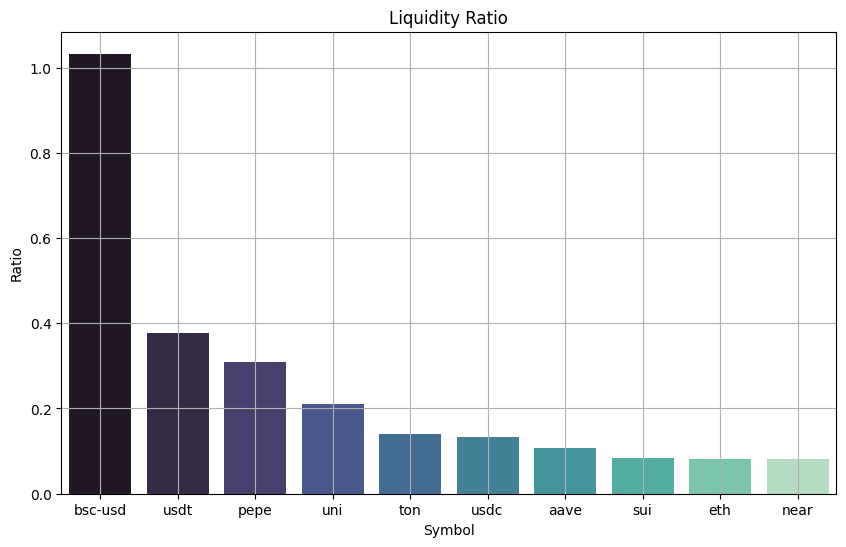

In [49]:
#vol/market cap ratio
import matplotlib.pyplot as plt
import seaborn as sns

df['liquidity_ratio'] = df['total_volume'] / df['market_cap']
top_liquid = df.sort_values(by='liquidity_ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_liquid, x='symbol', y='liquidity_ratio', palette='mako')
plt.title("Liquidity Ratio")
plt.ylabel("Ratio")
plt.xlabel("Symbol")
plt.grid(True)
plt.show()


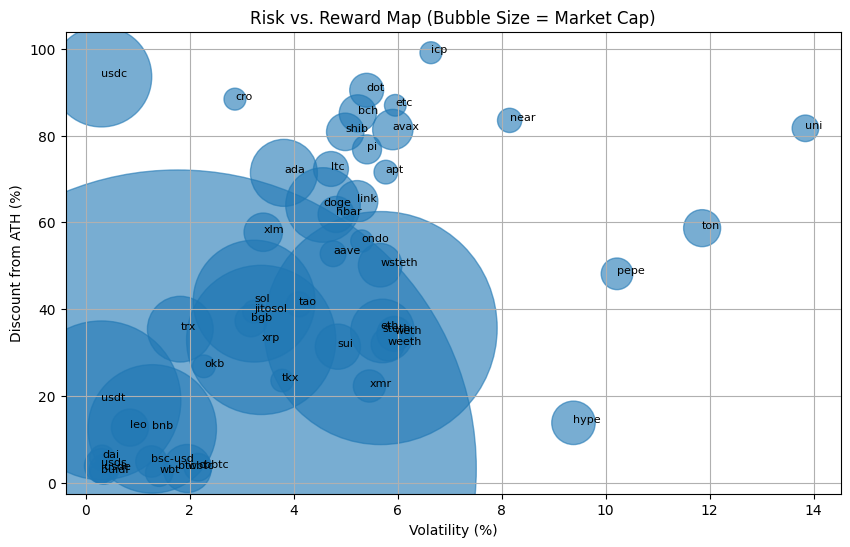

In [50]:
#risk vs reward
plt.figure(figsize=(10, 6))
plt.scatter(df['volatility_%'], df['ath_discount_%'], s=df['market_cap'] / 1e9, alpha=0.6)

for _, row in df.iterrows():
    plt.text(row['volatility_%'], row['ath_discount_%'], row['symbol'], fontsize=8)

plt.xlabel("Volatility (%)")
plt.ylabel("Discount from ATH (%)")
plt.title("Risk vs. Reward Map (Bubble Size = Market Cap)")
plt.grid(True)
plt.show()


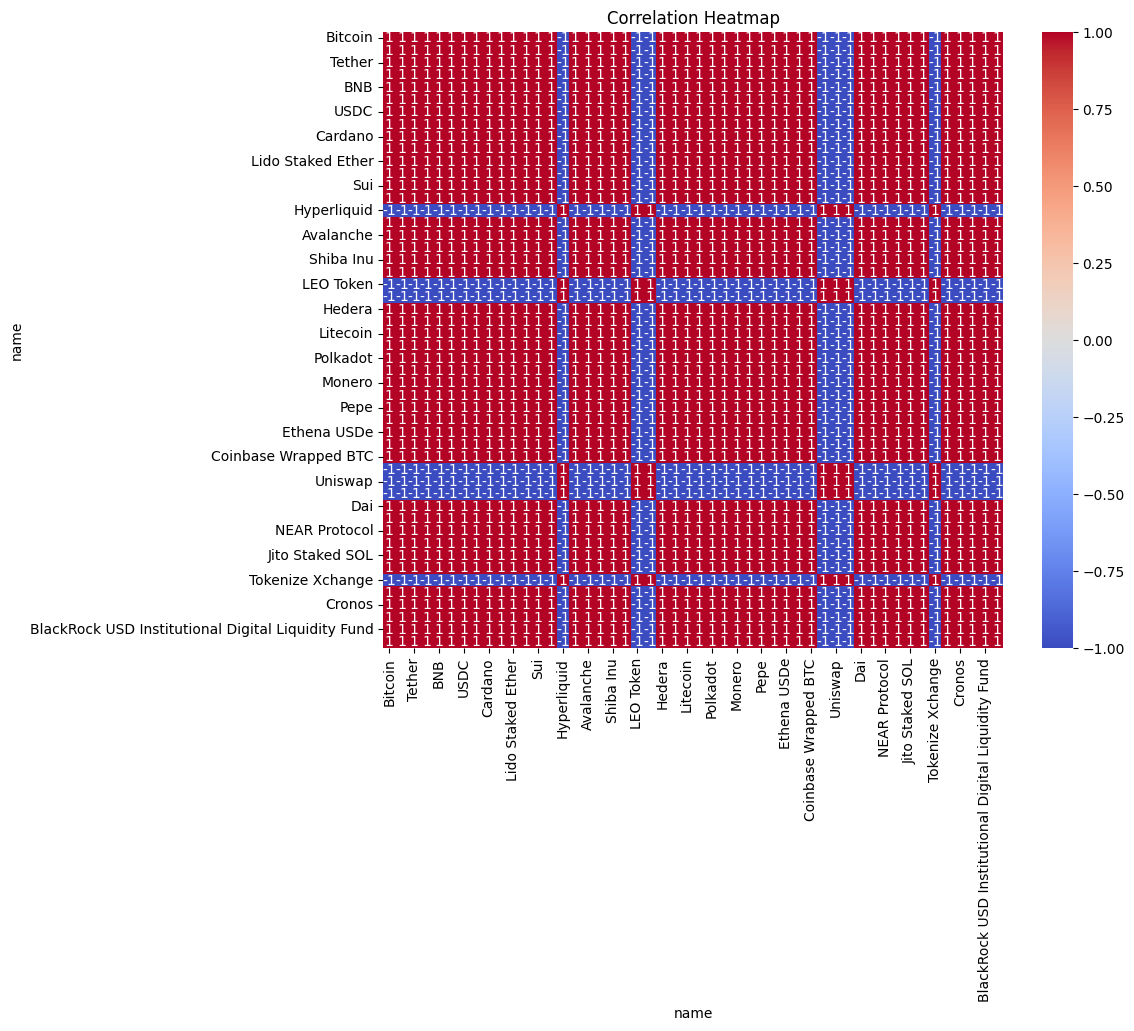

In [51]:
#correlational heatmap
price_cols = ['name', 'price_change_percentage_24h', 'price_change_percentage_7d_in_currency']

df_corr = df[price_cols].dropna().set_index('name')
corr_matrix = df_corr.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [52]:
fetch_and_plot_historical_price(days=30)


2025-05-29 12:10:43.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10:43.631 Session state does not function when running a script without `streamlit run`
2025-05-29 12:10:43.633 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-29 12:10

,timestamp,price,MA_7,MA_14
0,2025-04-30 00:00:00,8.027697e+06,NaN,NaN
1,2025-05-01 00:00:00,7.968689e+06,NaN,NaN
2,2025-05-02 00:00:00,8.167059e+06,NaN,NaN
3,2025-05-03 00:00:00,8.196935e+06,NaN,NaN
4,2025-05-04 00:00:00,8.118000e+06,NaN,NaN
5,2025-05-05 00:00:00,7.973099e+06,NaN,NaN
6,2025-05-06 00:00:00,7.980688e+06,8.061738e+06,NaN
7,2025-05-07 00:00:00,8.207545e+06,8.087431e+06,NaN
8,2025-05-08 00:00:00,8.229540e+06,8.124695e+06,NaN
9,2025-05-09 00:00:00,8.868162e+06,8.224853e+06,NaN


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Sample existing df schema for demonstration
# Let's assume df is already fetched and has these columns:
df = pd.DataFrame({
    'id': ['bitcoin', 'ethereum', 'solana', 'cardano', 'uniswap', 'chainlink', 'aave', 'sandbox'],
    'symbol': ['btc', 'eth', 'sol', 'ada', 'uni', 'link', 'aave', 'sand'],
    'current_price': [29000, 1800, 24, 0.5, 5.2, 7.3, 80, 0.35],
    'market_cap': [600e9, 250e9, 10e9, 9e9, 3e9, 5e9, 1e9, 0.5e9],
    'total_volume': [25e9, 15e9, 2e9, 1.5e9, 0.9e9, 1.1e9, 0.4e9, 0.3e9],
    'volatility_%': [2.5, 3.2, 5.5, 4.1, 6.0, 3.9, 7.2, 5.8],
    'ath_change_percentage': [-55, -65, -80, -75, -60, -70, -85, -90],
    'price_change_percentage_24h': [1.2, -0.8, 3.4, -2.1, 5.6, -1.0, 6.3, -3.2]
})

# Add ATH Discount and Liquidity Ratio
df['ath_discount_%'] = -df['ath_change_percentage']
df['liquidity_ratio'] = df['total_volume'] / df['market_cap']

# --- Add-on 2: Sector-wise Grouping ---
sector_map = {
    'bitcoin': 'Layer 1',
    'ethereum': 'Layer 1',
    'solana': 'Layer 1',
    'cardano': 'Layer 1',
    'uniswap': 'DeFi',
    'chainlink': 'Oracle',
    'aave': 'DeFi',
    'sandbox': 'NFT/Gaming'
}
df['sector'] = df['id'].map(sector_map)

sector_summary = df.groupby('sector').agg({
    'market_cap': 'sum',
    'price_change_percentage_24h': 'mean'
}).reset_index()

# --- Add-on 3: Risk Meter ---
df['risk_score'] = (
    0.5 * df['volatility_%'].rank(pct=True) +
    0.3 * df['ath_discount_%'].rank(pct=True) +
    0.2 * (1 - df['liquidity_ratio']).rank(pct=True)
) * 100

top_risk = df.sort_values(by='risk_score', ascending=False).head(10)

# Visualize all
print("📊 Sector-wise Summary")
display(sector_summary)

print("\n🚨 Top Risky Coins")
display(top_risk)


📊 Sector-wise Summary


,sector,market_cap,price_change_percentage_24h
0,DeFi,4.000000e+09,5.950
1,Layer 1,8.690000e+11,0.425
2,NFT/Gaming,5.000000e+08,-3.200
3,Oracle,5.000000e+09,-1.000



🚨 Top Risky Coins


,id,symbol,current_price,market_cap,total_volume,volatility_%,ath_change_percentage,price_change_percentage_24h,ath_discount_%,liquidity_ratio,sector,risk_score
6,aave,aave,80.00,1.000000e+09,4.000000e+08,7.2,-85,6.3,85,0.400000,DeFi,81.25
7,sandbox,sand,0.35,5.000000e+08,3.000000e+08,5.8,-90,-3.2,90,0.600000,NFT/Gaming,70.00
2,solana,sol,24.00,1.000000e+10,2.000000e+09,5.5,-80,3.4,80,0.200000,Layer 1,66.25
3,cardano,ada,0.50,9.000000e+09,1.500000e+09,4.1,-75,-2.1,75,0.166667,Layer 1,58.75
4,uniswap,uni,5.20,3.000000e+09,9.000000e+08,6.0,-60,5.6,60,0.300000,DeFi,58.75
5,chainlink,link,7.30,5.000000e+09,1.100000e+09,3.9,-70,-1.0,70,0.220000,Oracle,43.75
1,ethereum,eth,1800.00,2.500000e+11,1.500000e+10,3.2,-65,-0.8,65,0.060000,Layer 1,41.25
0,bitcoin,btc,29000.00,6.000000e+11,2.500000e+10,2.5,-55,1.2,55,0.041667,Layer 1,30.00


In [57]:
# ✅ Sample Portfolio Simulator

def portfolio_simulator(df):
    print("📊 Portfolio Simulator")
    print("Enter your portfolio holdings below:")

    # Create an empty portfolio list
    portfolio = []

    while True:
        coin = input("Enter coin symbol (e.g., BTC, ETH) or type 'done' to finish: ").lower()
        if coin == 'done':
            break
        amount = float(input(f"Enter investment amount in ₹ for {coin.upper()}: "))
        portfolio.append({'symbol': coin, 'amount_inr': amount})

    # Convert to DataFrame
    pf_df = pd.DataFrame(portfolio)

    # Merge with crypto data
    merged = pf_df.merge(df[['symbol', 'current_price', 'volatility_%', 'ath_discount_%']], on='symbol', how='left')

    # Calculate current holdings in units
    merged['units'] = merged['amount_inr'] / merged['current_price']
    merged['current_value'] = merged['units'] * merged['current_price']
    merged['gain_%'] = ((merged['current_value'] - merged['amount_inr']) / merged['amount_inr']) * 100

    # Final Portfolio Overview
    print("\n📈 Portfolio Performance Summary:")
    display(merged[['symbol', 'amount_inr', 'current_value', 'gain_%', 'volatility_%', 'ath_discount_%']])

    total_investment = merged['amount_inr'].sum()
    total_value = merged['current_value'].sum()
    total_return = ((total_value - total_investment) / total_investment) * 100

    print(f"\n💰 Total Investment: ₹{total_investment:,.0f}")
    print(f"📈 Current Value: ₹{total_value:,.0f}")
    print(f"📊 Total Return: {total_return:.2f}%")

    return merged


In [59]:
portfolio_results = portfolio_simulator(df)


📊 Portfolio Simulator
Enter your portfolio holdings below:
Enter coin symbol (e.g., BTC, ETH) or type 'done' to finish: BTC ETH
Enter investment amount in ₹ for BTC ETH: 20000
Enter coin symbol (e.g., BTC, ETH) or type 'done' to finish: DONE

📈 Portfolio Performance Summary:


,symbol,amount_inr,current_value,gain_%,volatility_%,ath_discount_%
0,btc eth,20000.0,NaN,NaN,NaN,NaN



💰 Total Investment: ₹20,000
📈 Current Value: ₹0
📊 Total Return: -100.00%
